# Диплом (часть 2)

## Условие проекта

В компании SkyCrossroads есть рекламная акция, в соответствии с которой клиенту дается возможность получить дополнительные баллы лояльности за покупку, совершенную в течение ограниченного периода времени после запуска акции. 

Классическая акция подразумевает получение дополнительные 1000 баллов лояльности за покупку от 100 рублей. Было решено запустить АБ Тест, в котором в тестовой группе предлагается в два раза больше баллов лояльности за покупку от 100 рублей. 

Эксперимент был проведен в нескольких торговых точках, которые в датасете представлены столбцом id_point.  Также в датасете есть информация о том, как долго клиент уже зарегистрирован у нас в программе лояльности.

Отдел маркетинга попросил вас рассчитать результаты этого эксперимента (в целом и в отдельности по каждой точке) и вынести решение об эффективности воздействия Б по сравнению с воздействием А. Также проведите сегментацию пользователей с точки зрения из длительности регистрации.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats
import random as rd
from scipy.stats import t

In [4]:
df = pd.read_csv('Dataset_AB_TEST.csv', sep = ';')

## Общий анализ АБ Теста

In [5]:
df.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10976 entries, 0 to 10975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_client   10976 non-null  int64  
 1   id_group    10902 non-null  object 
 2   sum_pay     10849 non-null  float64
 3   id_point    10895 non-null  float64
 4   months_reg  10976 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 428.9+ KB


In [7]:
# Проведем очистку данных от нуллов и выбросов

df = df.dropna()

In [8]:
df

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14
...,...,...,...,...,...
10971,1359021,control,799.0,1178.0,3
10972,1363347,control,4825.0,1178.0,6
10973,1373031,test,673.0,1179.0,1
10974,1370292,test,1120.0,1179.0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_client   10840 non-null  int64  
 1   id_group    10840 non-null  object 
 2   sum_pay     10840 non-null  float64
 3   id_point    10840 non-null  float64
 4   months_reg  10840 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 508.1+ KB


In [10]:
# Создадим функцию statistical_analysis, которая считает среднее значение, медиану, квартили, децили
# и строит гистограмму


def statistical_analysis(r, q= [0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9]):
    if type(r) != tuple and type(r) != list:
        return print('Нужен список или кортеж!')
    
    if len(r) <= 4:
        return print('Требуется более длинный ряд')
    
    r = pd.Series(r)
    mean = r.mean()
    var = r.var()
    std = r.std()
    
    print('Среднее: ',mean)  
    print('Дисперсия: ', var)
    print('Стандартное отклонение: ', std)
    
    qs = np.quantile(r,q)
    for i in range(len(q)):
        if q[i] == 0.1:
            print('1 дециль: ', qs[i])
        elif q[i] == 0.25:
            print('1 квартиль: ', qs[i])
        elif q[i] == 0.3:
            print('3 дециль: ', qs[i])
        elif q[i] == 0.4:
            print('4 дециль: ', qs[i])
        elif q[i] == 0.5:
            print('Медиана: ', qs[i])
        elif q[i] == 0.6:
            print('6 дециль: ', qs[i])
        elif q[i] == 0.75:
            print('3 квартиль: ', qs[i])
        elif q[i] == 0.9:
            print('9 дециль: ', qs[i])
            
        sns.histplot(r)
            
    return mean, var, std, qs

Среднее:  3568.7580258302582
Дисперсия:  8568932.941996625
Стандартное отклонение:  2927.27397795229
1 дециль:  410.0
1 квартиль:  1250.75
3 дециль:  1590.0
4 дециль:  2329.6000000000004
Медиана:  3173.5
6 дециль:  3934.0
3 квартиль:  5356.5
9 дециль:  7088.200000000001


(3568.7580258302582,
 8568932.941996625,
 2927.27397795229,
 array([ 410.  , 1250.75, 1590.  , 2329.6 , 3173.5 , 3934.  , 5356.5 ,
        7088.2 ]))

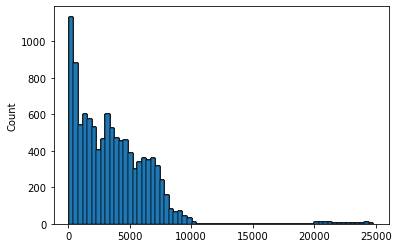

In [11]:
# Приеним функцию statistical_analysis к столбцу 'sum_pay', чтобы определить, есть ли выбросы

statistical_analysis(list(df['sum_pay']))

In [12]:
# Избавимся от выбросов. В нашем случае выбросами являются оплаты с суммой более 12 000 руб.

df1 = df.loc[df['sum_pay']<12000]

Среднее:  3431.3779388532666
Дисперсия:  6023895.900736336
Стандартное отклонение:  2454.3626261692334
1 дециль:  409.0
1 квартиль:  1237.0
3 дециль:  1576.0
4 дециль:  2307.0
Медиана:  3155.0
6 дециль:  3899.0
3 квартиль:  5274.0
9 дециль:  7011.0


(3431.3779388532666,
 6023895.900736336,
 2454.3626261692334,
 array([ 409., 1237., 1576., 2307., 3155., 3899., 5274., 7011.]))

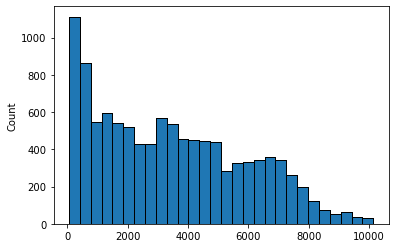

In [13]:
# Приеним функцию statistical_analysis к отредактированным данным

statistical_analysis(list(df1['sum_pay']))

In [14]:
df1.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


In [15]:
# Разобьем данные по сумме оплат отдельно для тестовой и контрольной группы 

df_control = df1.loc[df1['id_group'] == 'control']
control = df_control['sum_pay']

df_test = df1.loc[df1['id_group'] == 'test']
test = df_test['sum_pay']

In [16]:
# Создадим функцию для визуализации с помощью гистограммы результатов в А и Б группе 

def show_hist(k1, k2):
    
    plt.figure(figsize = (10,5))
    plt.title('Гистограмма распределения в группе А(оранжевый) и группе Б (голубой)') 
    
    plt.grid()
    
    sns.histplot(k1, color = 'tab:orange' )
    sns.histplot(k2, color = 'tab:cyan')
    
    #отрисовываем среднее k1 пунктирной черной линией толщиной 2
    plt.axvline(k1.mean(),     
            color='k', 
            linestyle='--', 
            linewidth=2, 
            label = f'среднее в группе А, {round(k1.mean(),2)}')

    #отрисовываем среднее k2 красной линией толщиной 2
    plt.axvline(k2.mean(), 
            color='r', 
            linestyle='-', 
            linewidth=2, 
            label = f'среднее в группе В, {round(k2.mean(),2)}')
    
    plt.legend()
    
    plt.show() 
    
    delta = round(((k2.mean()- k1.mean())/k1.mean())*100, 2)
    print(f'Прирост среднего чека составил {delta} %')


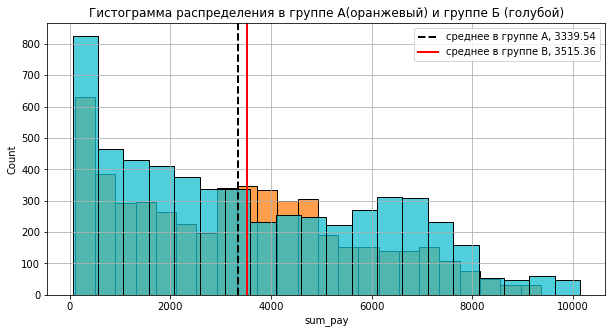

Прирост среднего чека составил 5.26 %


In [17]:
show_hist(control, test)

In [18]:
# Используем тест Шапиро: его -p_value говорит нам о том, нормально ли наше распределение

w, pvalue = stats.shapiro(control)
w, pvalue

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.953092634677887, 9.575525306395145e-38)

In [19]:
w, pvalue = stats.shapiro(test)
w, pvalue

(0.9342670440673828, 2.382207389352189e-44)

По результатам теста Шапиро можно сделать вывод о том, что оба распределения (в контрольной группе и тестовой группе) являются нормальными. p-value у обоих распределений имеет достаточно большое значение для такого заключения (p-value > alpha). Соответственно средние значения в этих распределениях тоже будут нормальными и для анализа можно использовать параметрические методы проверки нулевой гипотезы о равенстве средних.

In [20]:
# Создадим функцию mann_whitney_func, которая берет на вход два ряда и уровень значимости 
# Данная функция выполняет следующие действия:
    # Возвращает (в return) — значение статистики Манна — Уитни и p_value нулевой гипотезы.
    # Принт результата в зависимости от соотношения p_value и alpha («Распределения (не) равны»).

def mann_whitney_func(r1, r2, alpha = 0.05):
    
    s, p = stats.mannwhitneyu(r1, r2, alternative = 'two-sided')
    
    print('Значение статистики Манна — Уитни = ', s)
    print('p_value = ', p)
    print()
    
    if p < alpha:
        print('Распределения не равны')
    else:
        print('Распределения равны')
        
    return s, p

In [21]:
# Построим функцию, которая на вход берет два ряда и уровень значимости альфа.
# Функция возвращает значение двухвыборочного t-критерия и соответствующее ему p_value. 
# Также функция принтит, принимается ли нулевая гипотеза о равенстве средних или нет на основании полученного p_value.


def test_calc(l1, l2, alpha = 0.05):
    s1, p1 = ttest_ind(l1,l2)
    print('Значение двухвыборочного t-критерия: ', s1)
    print('Значение p-value: ', p1)
    
    if p1 < alpha:
        print('Гипотеза о равенстве средних не принимается')
    else:
        print('Гипотеза о равенстве средних принимается')
    return s1, p1

In [22]:
# Посмотрим на результаты параметрического  теста, используйте функцию test_calc

test_calc(control, test)

Значение двухвыборочного t-критерия:  -3.7141912292177888
Значение p-value:  0.0002048855494553075
Гипотеза о равенстве средних не принимается


(-3.7141912292177888, 0.0002048855494553075)

In [23]:
# Посмотрим на результаты непараметрического  теста, используйте функцию mann_whitney_func

mann_whitney_func(control, test)

Значение статистики Манна — Уитни =  14141330.5
p_value =  0.05842125879702285

Распределения равны


(14141330.5, 0.05842125879702285)

### Вывод:

По данным непараметрического теста Манна-Уитни распределения равны, то есть нет существенной разницы между тестовой и контрольной группой. При этом средние значения суммы оплаты в тестовой и контрольной группах отличаются. Об этом говорит результат параметрического теста (t-критерий Стьюдента).

То есть по результатам А/В теста по всем пользователям можно говорить об успешности данного эксперимента. Тестируемые изменения привели к увеличению среднего чека на 5.26 % в тестовой группе по сравнению с контрольной.

## Анализ по торговым точкам

In [24]:
df1.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


In [25]:
# Посмотрим, какие есть уникальные точки в нашем датасете

points = df1['id_point'].unique()

points

array([1199., 1182., 1178., 1179., 1186., 1188.])

1199.0


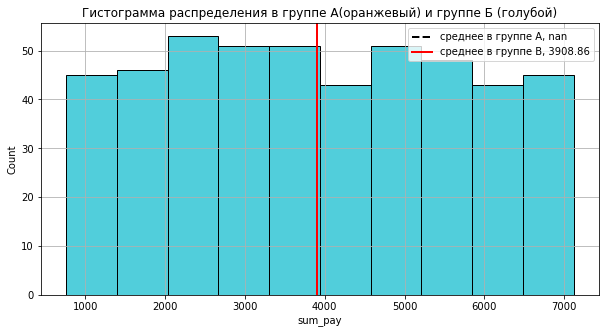

Прирост среднего чека составил nan %
Недостаточное количество наблюдений для данной точки
1182.0


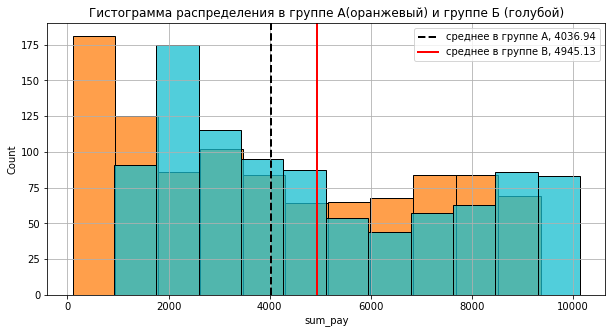

Прирост среднего чека составил 22.5 %
Значение статистики Манна — Уитни =  382818.5
p_value =  5.946812205351181e-15

Распределения не равны
Значение двухвыборочного t-критерия:  -7.172588995409098
Значение p-value:  1.0387447468996453e-12
Гипотеза о равенстве средних не принимается
1178.0


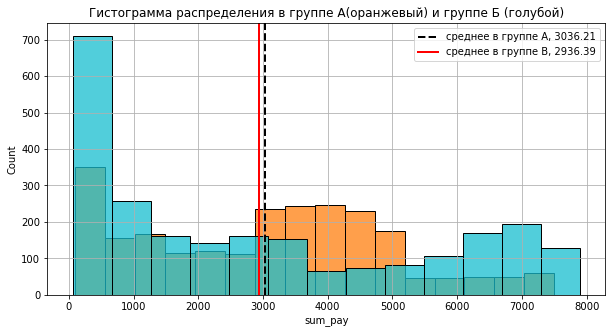

Прирост среднего чека составил -3.29 %
Значение статистики Манна — Уитни =  3122337.5
p_value =  1.5133330174771163e-06

Распределения не равны
Значение двухвыборочного t-критерия:  1.5338932633911708
Значение p-value:  0.1251217226713009
Гипотеза о равенстве средних принимается
1179.0


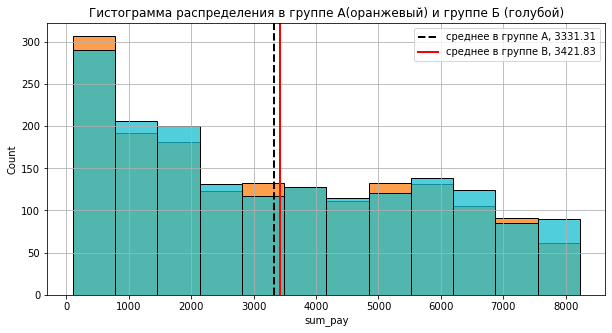

Прирост среднего чека составил 2.72 %
Значение статистики Манна — Уитни =  1447666.5
p_value =  0.2580763851815786

Распределения равны
Значение двухвыборочного t-критерия:  -1.1225576641441302
Значение p-value:  0.2617037465196552
Гипотеза о равенстве средних принимается
1186.0


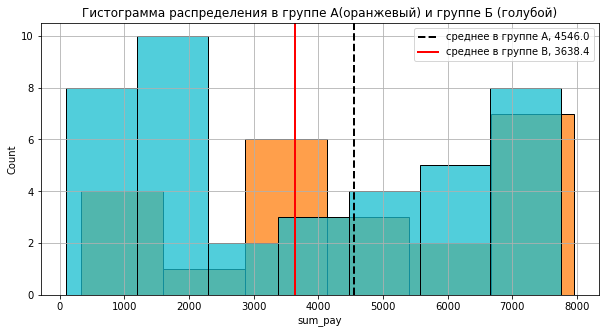

Прирост среднего чека составил -19.96 %
Недостаточное количество наблюдений для данной точки
1188.0


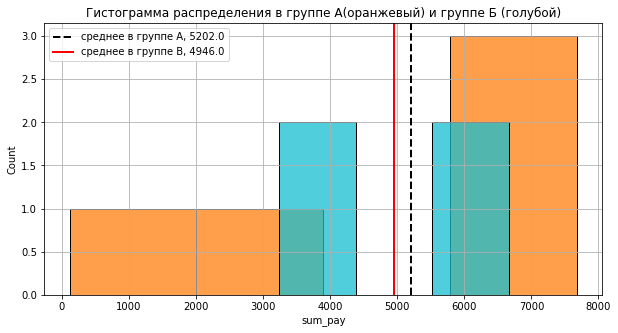

Прирост среднего чека составил -4.92 %
Недостаточное количество наблюдений для данной точки


In [26]:
# Создадим цикл, пробегающий по всем уникальным торговым точкам

for i in points:
    
    df_control = df1.loc[(df1['id_group'] == 'control') & (df1['id_point'] == i)]
    control = df_control['sum_pay']
    
    df_test = df1.loc[(df1['id_group'] == 'test') & (df1['id_point'] == i)]
    test = df_test['sum_pay']
   
    print(i)
    show_hist(control, test)
    
    if len(control)>=100 and len(test)>=100:
        mann_whitney_func(control, test)
        test_calc(control, test)
    
    else:
        print('Недостаточное количество наблюдений для данной точки')


### Вывод:

Анализ по торговым точкам показал, что для достоверного анализа не по всем точкам было рассмотрено достаточное количество продаж. 

Для точки 1199 есть данные только по тестовой группе и отсутствуют данные по контролной, и предоставленных данных недостаточно для корректрого анализа. 
Для точек 1186, 1188 есть данные по обоим группам, но количества наблюдений недостаточно для анализа. У этого может быть две причины. 
Первая: что просто не было набрано достаточное количество наблюдений. Тогда рекомендуется набрать больше наблюдений по продажам в контрольной и тестовой группах и повторить проведенный анализ.
Вторая причина: по этим точкам в принципе совершалось мало продаж, поэтому данных недостаточно. Необходимо оценить эти точки с позиции их эффективности: сколько там проводится продаж, какие факторы на это влияют (возможно, неудачная локация офиса, неудачный интерфейс сайта и т.п.)

Из имеющихся данных можно сделать вывод лишь по трем точкам 1182, 1178, 1179.

В точке 1182 эксперимент прошел успешно. Прирост среднего чека составил 22.5 %. И это не случайность, а статистически закономерное событие. 

А в точках 1178 и 1179 эксперимент прошел неудачно. Результатов воздействия тестируемых изменений на величину среднего чека не выявлено.

## Сегментация по длительности регистрации

In [27]:
df1.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


In [28]:
# Создадим функцию proxi_ranges, которая берет на вход два ряда и уровень значимости 
# Данная функция выполняет следующие действия:
    # Вычисляет дисперсии рядов и их ковариацию с помощью функции cov из numpy 
    # Вычисляет корреляцию Пирсона и корреляцию Спирмена и p_value этих корреляций.
    # Принтит результаты корреляционного анализа: корреляция равна нулю, если p_value больше альфы. 
        # В противном случае принтит, является ли корреляция слабой (меньше 0.3), средней (от 0.3 до 0.7) 
            #или сильной (больше 0.7).


def proxi_ranges(r1, r2, alpha = 0.05):
    
    cov_matrix = np.cov(r1, r2)
    pearsonr_v, pearsonr_p = pearsonr(r1, r2)
    spearmanr_v, spearmanr_p = spearmanr(r1, r2)
    
    print('Дисперсия ряда', r1.name, '=', cov_matrix[0,0])
    print('Дисперсия ряда', r2.name, '=', cov_matrix[1,1])
    print('Ковариация = ', cov_matrix[0,1])
    print()
    
    
    if pearsonr_p < alpha:
        print('Корреляция Пирсона = ', pearsonr_v)
        if abs(pearsonr_v) < 0.3:
            print('Корреляция слабая')
        elif abs(pearsonr_v) < 0.7:
            print('Корреляция средняя')
        else:
            print('Корреляция сильная')
    else:
        print('Корреляция Пирсона равна нулю')
    print()
    

    if spearmanr_p < alpha:
        print('Корреляция Спирмена = ', spearmanr_v)
        if abs(spearmanr_v) < 0.3:
            print('Корреляция слабая')
        elif abs(spearmanr_v) < 0.7:
            print('Корреляция средняя')
        else:
            print('Корреляция сильная')
    else:
        print('Корреляция Спирмена равна нулю')

In [29]:
# Используя функцию proxi_ranges, рассмотрим два вида корреляции между 
# выплаченной суммой и длительностью регистрации.

proxi_ranges(df1['sum_pay'], df1['months_reg'])

Дисперсия ряда sum_pay = 6023895.900736308
Дисперсия ряда months_reg = 10.039582493438866
Ковариация =  4652.627890558256

Корреляция Пирсона =  0.598276252133036
Корреляция средняя

Корреляция Спирмена =  0.6520008575703581
Корреляция средняя


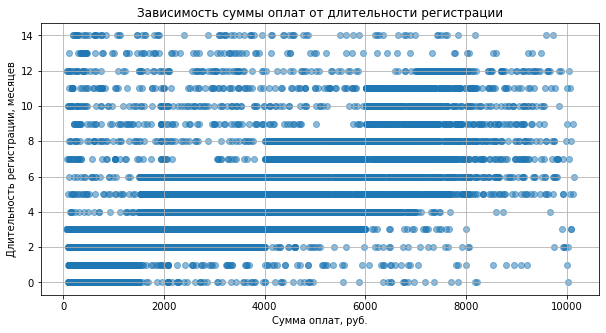

In [30]:
plt.figure(figsize = (10,5))

plt.title('Зависимость суммы оплат от длительности регистрации') 
plt.xlabel('Сумма оплат, руб.') 
plt.ylabel('Длительность регистрации, месяцев') 

plt.grid()

plt.scatter(df1['sum_pay'], df1['months_reg'], alpha = 0.5)
plt.show()

In [37]:
# Проведем группировку пользователей по длительности регистрации и посчитаем средний чек для каждой группы.

monthly = df1.groupby('months_reg')['sum_pay'].mean().reset_index()
monthly.columns = ['months_reg', 'avg_sum_pay']

monthly

,months_reg,avg_sum_pay
0,0,980.297092
1,1,1085.724051
2,2,1777.822569
3,3,2373.030285
4,4,3762.609551
5,5,4053.715359
6,6,4319.829308
7,7,5613.047913
8,8,5573.013595
9,9,5946.964169


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Величина среднего чека по длительности регистрации'}, xlabel='Длительность регистрации, мес.', ylabel='Средний чек, руб.'>

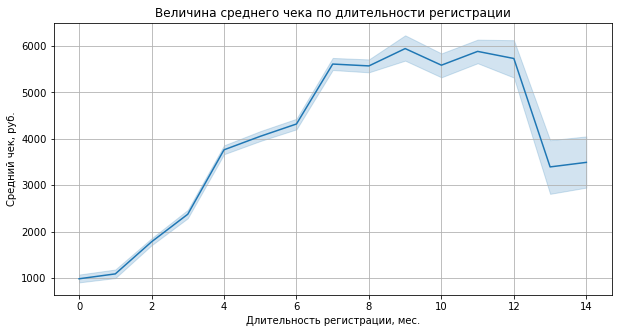

In [38]:
# Визуализируем данные с помощью графика.

plt.figure(figsize = (10,5))

plt.title('Величина среднего чека по длительности регистрации') 
plt.xlabel('Длительность регистрации, мес.') 
plt.ylabel('Средний чек, руб.') 

plt.grid()

sns.lineplot(df1['months_reg'],
             df1['sum_pay'])

## Вывод
Корреляция между выплаченной суммой и длительностью регистрации прямая, средняя и ярко выраженная. 
При этом в первые семь месяцев сумма среднего чека активно растет. После семи месяцев она выходит на плато, а через год после регистрации происходит резкий спад суммы среднего чека.

Исходя из этого, можно дать рекомендацию маркетингу, проявить больше внимания к пользователям, чья длительность регистрации более семи месяцев: вовлекать их в покупки с помощью промо-акций и скидок. 

И особое внимание уделить пользователям, которые зарегистрированы на сайте больше года. Рекомендуется проводить холодные звонки для данного сегмета. Предлагать особые условия покупок для давних клиентов, которые являются пользователями больше года.